## Exercise 3 - Challenge: Solve Laplace’s equation in 1D

---

```python
Auther = 'Yubo Cai'
Email = 'yubo.cai@polytechnique.edu'
```

<div style="background-color:lightblue;margin:20px;padding:10px;border-radius:10px;border-width:2px;border-color:black;box-shadow:5px 5px;width:95%">

---
To get one bonus point you need to:
- implement the Conjugate Gradient algorithm
- solve questions 1, 3: analytical solution, comparison of the numerical result to the analytical solution.
- solving optional questions (2., 5.) can give you additional points (depending on the quality of your notebook)

---

Given a function $f:[0,1] \rightarrow \mathbb{R}$ we want to solve the problem
$$
\left\{\begin{array}{l}
-u^{\prime \prime}=f \quad \text { in }(0,1) \\
u(0)=u(1)=0
\end{array}\right.
$$

**Question 1**

In some cases the explicit solution can be found. Find $u(x)$ when $f$ is constant and equal to 1.
</div>

In [1]:
import scipy.optimize as scopt
import numpy as np
import pylab as pl
from ipywidgets import *
import matplotlib.pyplot as plt
import sympy as sp

### Numerical solution

In order to approximate the solution $u$ for a general source function $f$, it is necessary to discretize the problem. In order to do this, consider a uniform discretization of the interval $(0,1)$
$$
0=x_0<x_1<\ldots<x_{N+1}=1, x_{i+1}-x_i=\frac{1}{N+1}
$$
and denote by $u_i$ the approximations of $f\left(x_i\right)$. Based on the Taylor expansion it is possible to approximate the first and second derivatives using finite differences in the following way:
$$
u^{\prime}(x) \approx \frac{u(x+h)-u(x)}{h} \quad u^{\prime \prime}(x) \approx \frac{u(x+h)+u(x-h)-2 u(x)}{h^2} .
$$
If $f_i$ is the value of $f$ at $x_i: f_i=f\left(x_i\right)$ then the equality $u^{\prime \prime}(x)=1$ written in discrete form is given by:
$$
\frac{2 u_i-u_{i+1}-u_{i-1}}{h^2}=f_i, i=1, \ldots, N
$$
where $h=\frac{1}{N}$ is the uniform step defined by the discretization. Also, since we have $f=1$ which implies $f_i=1$ for all $i$, the previous equation can be written as:
$$
u_{i+1} = 2u_i-u_{i-1}-h^2, i=1, \ldots, N
$$

### Analytical solution

For $f$ constant and equal to 1, we have $u''(x)=-1$. Integrating twice gives:
$$
u(x)=-\frac{1}{2}x^2+C_1x+C_2
$$
Applying the boundary conditions $u(0)=u(1)=0$ we get:
$$
u(x)=-\frac{1}{2}(x^2-x)
$$
So the explicit solution for this case is $u(x)=-\frac{1}{2}(x^2-x)$.

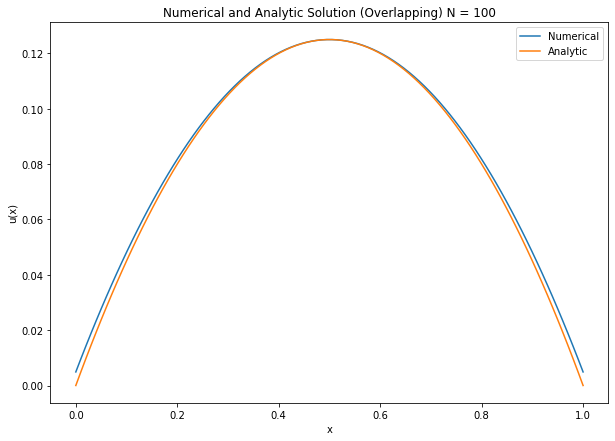

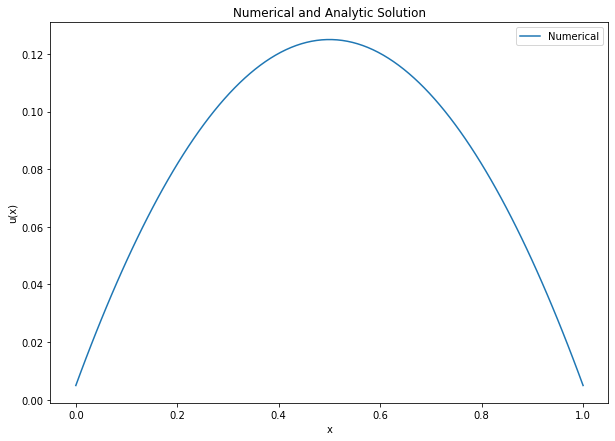

In [39]:
# Define the interval and the number of grid points
a = 0
b = 1
N = 100
h = 1 / (N+1)

def f(x):
    return 1

def f_analytic(x):
    return - 1/2 * (x ** 2 - x)

x = np.linspace(a, b, N)
y_analytic = f_analytic(x)

u_list = np.zeros(N+1)
u_list[0] = 0
u_list[1] = - 1/2 * (h ** 2 - h)
for i in range(1, N):
    u_list[i+1] = 2 * u_list[i] - u_list[i-1] - h ** 2 * f(x[i])
u_list = u_list[1:]

plt.figure(figsize=(10, 7))
plt.plot(x, u_list, label="Numerical")
plt.plot(x, y_analytic, label="Analytic")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Numerical and Analytic Solution (Overlapping) N = 100")
plt.legend()
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(x, u_list, label="Numerical")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Numerical and Analytic Solution")
plt.legend()
plt.show()

<div style="background-color:lightblue;margin:20px;padding:10px;border-radius:10px;border-width:2px;border-color:black;box-shadow:5px 5px;width:95%">

**Question 3**

After discretization, equation (1) becomes a linear system
$$
A U=F
$$
equivalent to the minimization problem
$$
\min _{U \in \mathbb{R}^N} \frac{1}{2} U^T A U-F^T U
$$
where $U=\left(u_1, \ldots, u_N\right)$ and $F=\left(f_1, \ldots, f_N\right)$. Moreover, the matrix $A$ has the form
$$
A=\frac{1}{h^2}\left(\begin{array}{ccccc}
2 & -1 & 0 & \cdots & 0 \\
-1 & 2 & -1 & \cdots & 0 \\
0 & -1 & 2 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & 2
\end{array}\right)
$$
Construct the matrix $A$ using the command scipy.sparse.diags which exploits the fact that the matrix is constant along some of its diagonals. In addition, with this definition the matrix $A$ is sparse and the memory space occupied is $O(N)$, where $N$ is the size of the discretization.

Solve the previously defined linear system for different values of $N$, noting that $A$ is symmetric, positive definite, so the Conjugate Gradient algorithm can be applied. Plot the solution and compare it with the analytical case when $f \equiv 1$. Try different other choices for the function $f$, noting that the discrete algorithm does not change (only the vector $F$ does).
</div>

In [41]:
def conjugate_gradient(A, b, x0, tol=1e-15, max_iter=2000):
    n = len(b)
    x = x0.copy()
    r = b - A @ x
    p = r.copy()
    if max_iter is None:
        max_iter = n
    for _ in range(max_iter):
        Ap = A @ p
        alpha = np.dot(r, r) / np.dot(p, Ap)
        x = x + alpha * p
        r_new = r - alpha * Ap
        if np.linalg.norm(r_new) < tol:
            break
        beta = np.dot(r_new, r_new) / np.dot(r, r)
        p = r_new + beta * p
        r = r_new
    return x

In [48]:
from scipy.sparse import diags

N = 100 # size of discretization
h = 1/(N+1) # step size

# Construct matrix A
diagonals = [[-1] * (N-1), [2] * (N), [-1] * (N-1)]
A = diags(diagonals, [-1, 0, 1]).toarray()
A = A / h**2
print('The size of A is', A.shape)

U = np.zeros(N) # initialize solution vector
# F is the vector base on function f
F = np.zeros(N)
for i in range(N):
    F[i] = f(x[i])

# Solve the linear system
U = conjugate_gradient(A, F, U)

The size of A is (100, 100)


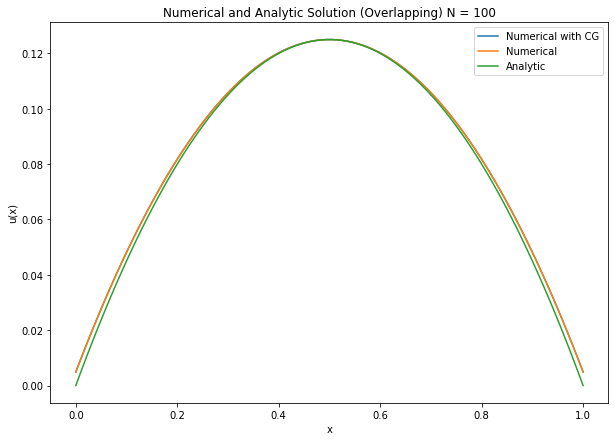

In [49]:
# Plot the solution
plt.figure(figsize=(10, 7))
plt.plot(x, U, label="Numerical with CG")
plt.plot(x, u_list, label="Numerical")
plt.plot(x, y_analytic, label="Analytic")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Numerical and Analytic Solution (Overlapping) N = 100")
plt.legend()
plt.show()


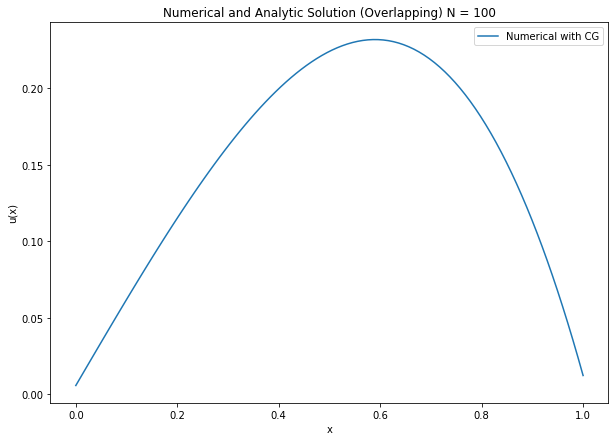

In [52]:
def f(x):
    return x**2 + 3*x

F = np.zeros(N)
for i in range(N):
    F[i] = f(x[i])

# Solve the linear system
U = conjugate_gradient(A, F, U)

# Plot the solution
plt.figure(figsize=(10, 7))
plt.plot(x, U, label="Numerical with CG")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Numerical and Analytic Solution (Overlapping) N = 100")
plt.legend()
plt.show()